In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50V2
import os
import pickle

In [ ]:
INIT_LR = 1e-5
EPOCHS = 20
BS = 256

img_rows = 224
img_cols = 224

In [ ]:
data = pickle.load(open('/content/drive/MyDrive/Capstone Project/Training1/data.pkl', 'rb'))
labels = pickle.load(open('/content/drive/MyDrive/Capstone Project/Training1/labels.pkl', 'rb'))
lb = pickle.load(open('/content/drive/MyDrive/Capstone Project/Training1/lb.pkl', 'rb'))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
print(data.shape)
print(labels.shape)

(6038, 224, 224, 3)
(6038, 3)


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
feature_extractor_layer = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_rows,img_cols,3)))

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Flatten(name="flatten"),
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              102761472 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 3075      
Total params: 126,329,347
Trainable params: 102,764,547
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
  loss="categorical_crossentropy",
  metrics=["accuracy"])

In [ ]:
import time
start = time.time()
history = model.fit(aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    epochs=EPOCHS)
print('\nTraining took {}'.format((time.time()-start)))

Epoch 1/20
18/18 [==============================] - 880s 49s/step - loss: 1.3638 - accuracy: 0.6828 - val_loss: 0.1318 - val_accuracy: 0.9768
Epoch 2/20
18/18 [==============================] - 868s 49s/step - loss: 0.1997 - accuracy: 0.9552 - val_loss: 0.1260 - val_accuracy: 0.9801
Epoch 3/20
18/18 [==============================] - 861s 48s/step - loss: 0.1402 - accuracy: 0.9637 - val_loss: 0.1068 - val_accuracy: 0.9801
Epoch 4/20
18/18 [==============================] - 877s 49s/step - loss: 0.1296 - accuracy: 0.9676 - val_loss: 0.0866 - val_accuracy: 0.9851
Epoch 5/20
18/18 [==============================] - 878s 49s/step - loss: 0.1045 - accuracy: 0.9720 - val_loss: 0.0730 - val_accuracy: 0.9884
Epoch 6/20
18/18 [==============================] - 899s 50s/step - loss: 0.0757 - accuracy: 0.9768 - val_loss: 0.0764 - val_accuracy: 0.9884
Epoch 7/20
18/18 [==============================] - 879s 49s/step - loss: 0.0808 - accuracy: 0.9792 - val_loss: 0.0774 - val_accuracy: 0.9859
Epoch 

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
print(predIdxs)

[[9.1253945e-08 1.0458102e-08 9.9999988e-01]
 [7.0983693e-02 9.2900711e-01 9.2461014e-06]
 [1.0000000e+00 2.1156785e-09 2.1218706e-12]
 ...
 [2.3261705e-06 5.9635660e-08 9.9999762e-01]
 [1.3550805e-07 9.9999988e-01 1.0172625e-10]
 [7.9314113e-08 9.9999988e-01 3.9169565e-14]]


In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)

[2 1 0 ... 2 1 1]


In [ ]:
print(testY[:3])

[[0 0 1]
 [0 1 0]
 [1 0 0]]


In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

                      precision    recall  f1-score   support

final_incorrect_mask       1.00      0.99      0.99       389
           with_mask       0.98      1.00      0.99       433
        without_mask       1.00      0.99      1.00       386

            accuracy                           0.99      1208
           macro avg       0.99      0.99      0.99      1208
        weighted avg       0.99      0.99      0.99      1208



In [ ]:
model.save("/content/drive/MyDrive/Capstone Project/Training1/mask_detector_resnet_20.model", save_format="h5")

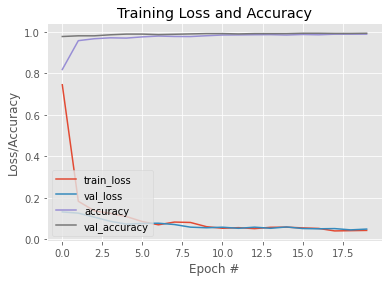

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_resnet_20.png")

In [ ]:
!mv plot_resnet_20.png /content/drive/MyDrive/Capstone\ Project/Training1/